In [1]:
# Import Libraries
from nsepy import get_history
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import talib as ta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Extract data from NSEPy
symbol = 'NIFTY'
start = date(2012,1,1)
end = date(2020,12,31)
df = get_history(symbol,start,end,index=True)
df = pd.DataFrame(df)

In [3]:
# Calculate technical indicators
df['EMA21'] = ta.EMA(df.Close,21)
df['EMA42'] = ta.EMA(df.Close,42)
df['EMA63'] = ta.EMA(df.Close,63)
df['MACD'],df['MACDSignal'],df['MACDHist'] = ta.MACD(df.Close,12,26,9)
df['ADX'] = ta.ADX(df.High,df.Low,df.Close,14)
df['FASTK'],df['FASTD'] = ta.STOCHF(df.High,df.Low,df.Close,5,3)
df['RSI'] = ta.RSI(df.Close,14)

In [4]:
# Strategy in action  
df['Buy_Strategy'] = (df['EMA21']>df['EMA42'])&(df['EMA42']>df['EMA63'])&(df['ADX']<=25)\
                    &(df['ADX']>df['ADX'].shift(1))&(df['MACDHist']>df['MACDHist'].shift(1))

df.loc[df.Buy_Strategy,'Buy_Trade'] = 1
df.loc[df.Buy_Trade.shift(1)==1,'Buy_Trade'] = " " 

df.Buy_Trade.iloc[-3:]  = " " 

# As this strategy requires squaring off in 4 days we shall avoid buying in the last 3 days of the data set
df.loc[df.Buy_Trade==1,'Buy_Price'] = df.Close
df.Buy_Price = df.Buy_Price.ffill()
df['Buy_Daily_Return']= (df.Close - df.Buy_Price)/df.Buy_Price
df.loc[df.Buy_Trade.shift(3)==1,'Sell_Trade'] = -1
df.loc[df.Sell_Trade==-1,'Buy_Total_Return'] = df.Buy_Daily_Return
df.loc[(df.Sell_Trade==-1)&(df.Buy_Daily_Return==0),'Buy_Total_Return'] = \
                                (df.Buy_Price - df.Buy_Price.shift(1))/df.Buy_Price.shift(1)
df.loc[(df.Sell_Trade==-1)&(df.Buy_Trade.shift(1)==1),'Buy_Total_Return'] = \
                                (df.Close-df.Buy_Price.shift(2))/df.Buy_Price.shift(2)

In [5]:
# Cumulative returns calculation & stats
df['Cumulative_Return'] = (1 + df.Buy_Total_Return).cumprod()
df['Final_Return'] = df.Cumulative_Return.ffill()
print('Cumulative Return',df.Final_Return[-1])
print('Hit Ratio - Train Df: ',sum(df.Buy_Total_Return > 0)/len(df.Cumulative_Return.value_counts()))
print(df.Cumulative_Return.describe())

Cumulative Return 1.4848092455641986
Hit Ratio - Train Df:  0.6666666666666666
count    78.000000
mean      1.213762
std       0.117640
min       0.990115
25%       1.123847
50%       1.210715
75%       1.296299
max       1.484809
Name: Cumulative_Return, dtype: float64


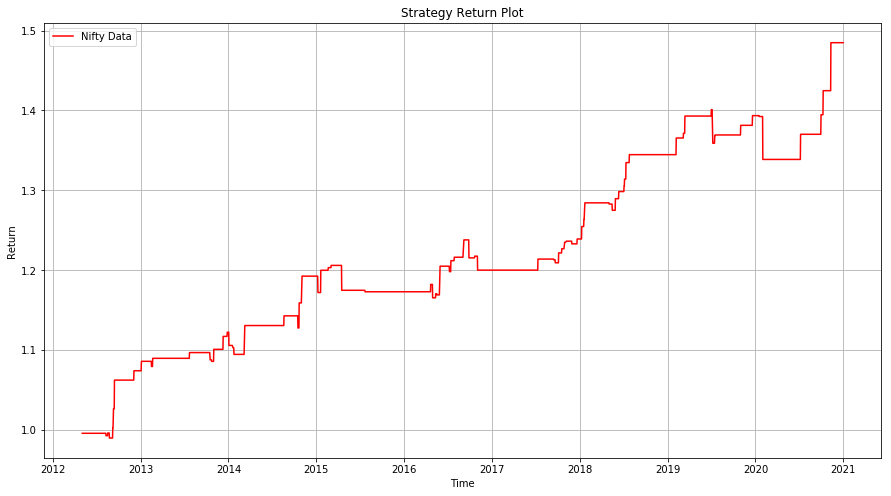

In [6]:
# Plot to analyse strategy return
plt.figure(figsize = (15,8))
plt.plot(df.Final_Return,'r')
plt.legend(['Nifty Data'])
plt.grid(True)
plt.title('Strategy Return Plot')
plt.xlabel('Time')
plt.ylabel('Return')
plt.show()

In [7]:
df.tail(50)

,Open,High,Low,Close,Volume,Turnover,EMA21,EMA42,EMA63,MACD,...,FASTD,RSI,Buy_Strategy,Buy_Trade,Buy_Price,Buy_Daily_Return,Sell_Trade,Buy_Total_Return,Cumulative_Return,Final_Return
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-21,11958.55,12018.65,11775.75,11937.65,623658140,3.747713e+11,11681.946069,11509.369704,11350.407529,150.892582,...,66.236441,63.074212,False,NaN,11662.4,0.023601,NaN,NaN,NaN,1.424764
2020-10-22,11890.00,11939.55,11823.45,11896.45,544901152,3.301317e+11,11701.446426,11527.373439,11367.471356,148.409131,...,68.575182,60.952689,False,NaN,11662.4,0.020069,NaN,NaN,NaN,1.424764
2020-10-23,11957.90,11974.55,11908.75,11930.35,502340361,2.742461e+11,11722.255842,11546.116535,11385.061313,147.476409,...,68.233995,62.082796,False,NaN,11662.4,0.022976,NaN,NaN,NaN,1.424764
2020-10-26,11937.40,11942.85,11711.70,11767.75,519815905,2.931602e+11,11726.391674,11556.425068,11397.020335,132.094061,...,49.024410,54.008640,False,NaN,11662.4,0.009033,NaN,NaN,NaN,1.424764
2020-10-27,11807.10,11899.05,11723.00,11889.40,616318543,3.798997e+11,11741.210613,11571.912274,11412.407199,128.241292,...,46.600020,58.370787,False,NaN,11662.4,0.019464,NaN,NaN,NaN,1.424764
2020-10-28,11922.60,11929.40,11684.85,11729.60,704018608,3.702589e+11,11740.155103,11579.246587,11422.319474,111.013723,...,30.533161,51.465390,False,NaN,11662.4,0.005762,NaN,NaN,NaN,1.424764
2020-10-29,11633.30,11744.15,11606.45,11670.80,554959844,3.043662e+11,11733.850094,11583.504885,11430.084491,91.560628,...,30.273614,49.160781,False,NaN,11662.4,0.000720,NaN,NaN,NaN,1.424764
2020-10-30,11678.45,11748.95,11535.45,11642.40,553672805,2.815158e+11,11725.536449,11586.244193,11436.719351,73.010646,...,19.726839,48.041790,False,NaN,11662.4,-0.001715,NaN,NaN,NaN,1.424764
2020-11-02,11697.35,11725.65,11557.40,11669.15,568434165,3.571457e+11,11720.410408,11590.100277,11443.982808,59.779057,...,25.890607,49.214361,False,NaN,11662.4,0.000579,NaN,NaN,NaN,1.424764
